# Harris Corner Detector

In [11]:
import numpy as np
from scipy import ndimage as nd
import math
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

old functions

In [12]:
# Gradient in x-direction
def Sobelx(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])
    Ix = nd.convolve(image,sobelx)           
    return Ix


# Gradient in y-direction
def Sobely(image):
    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Iy = nd.convolve(image,sobely)
    return Iy


# Convert RGB to grayscale
def rgb2gray(image):
    image = np.array(image)
    r, c, ch = image.shape
    gray = np.zeros([r,c])

    gray = np.mean(image, axis=2)
    return gray


# Reduce image size
def reduceRes(image,factor):
    r,c = image.size
    r = np.int(np.floor(r/factor))
    c = np.int(np.floor(c/factor))
    new = image.resize((r,c))
    return new


# Box filter for smoothing
def boxFilter(image,rc):
    box = np.ones([rc,rc])/rc**2
    image = nd.convolve(gray,box)
    return image


# Pad image with zeros
def pad(image,factor):
    r_img, c_img = image.shape
    pad = np.zeros([r_img,factor])
    image = np.hstack([pad,image,pad])

    r_img, c_img = image.shape
    pad = np.zeros([factor,c_img])
    image = np.vstack([pad,image,pad])

    return image


# Peak finding for nonmax supression
def peaks(image,window):
    factor = int(np.floor(window/2))
    image = pad(image,factor)
    peaks = np.zeros([image.shape[0],image.shape[1]])

    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            window = image[i-1:i+2,j-1:j+2]
            if image[i,j]==np.amax(window):
                peaks[i,j] = image[i,j]


    # remove padding
    peaks = peaks[factor:-factor,factor:-factor]

    return peaks


# Norm CC feature matching
def norm_cross_corr(image,filter):
    r,c = image.shape
    ncc = np.zeros([r,c])
    
    add = np.int((filter.shape[0]-1)/2)
    padded = pad(image,add)

    for i in range(r):
        for j in range(c):
            f = padded[i:i+filter.shape[0],j:j+filter.shape[1]]
            if np.sum(np.sqrt(f**2))==0:
                norm_f = np.zeros([f.shape[0],f.shape[1]])
            else:
                norm_f = f/np.sqrt(np.sum(f**2))
            norm_g = filter/np.sqrt(np.sum(filter**2))

            norm_f = np.reshape(norm_f,[1,filter.size])
            norm_g = np.reshape(norm_g,[filter.size,1])

            ncc[i,j] = np.dot(norm_f,norm_g)
            
    return ncc

Functions for project 2

In [22]:
# Harris Corner Detector
def HarrisCorner(image,threshold):

    # Find gradients
    Ix = Sobelx(image)
    Iy = Sobely(image)
    Ixx = Ix**2
    Iyy = Iy**2

    # Compute R values
    detM = Ixx*Iyy
    traceM = Ixx+Iyy
    k = 0.05
    R = detM - k*traceM**2

    # Threshold values
    R[R <= threshold*np.amax(R)] = 0
    
    # Nonmax Supression
    R = peaks(R,3)

    return R


# Reduce threshold until ~1% of pixels are corners
def reducedHarris(image,ratio):
    threshold = 1.0
    while ratio >= 100:
        threshold = 0.1*threshold

        corners = HarrisCorner(image,threshold)
        # Number of corners
        idx = np.where(corners>0)
        idx = np.array(idx).T
        ratio = image.size/idx.shape[0]

    print('Threshold:',threshold)
    print('Corners:',idx.shape[0])

    return corners


# Improve corners from HCD
def neighboringCorner(corners,width,num_corners):
    # Remove isolated corners in a window

    good_corners = np.copy(corners)
    good_corners[good_corners>0] = 1
    good_corners[good_corners<0] = 0
    print('Previous corners:', np.sum(good_corners))

    filter = np.ones([width,width])
    neighbors = nd.convolve(good_corners,filter)

    neighbors[neighbors<num_corners] = 0
    neighbors[neighbors>=num_corners] = 1
    neighbors = neighbors*good_corners

    print('Better corners:',np.sum(neighbors))

    return corners*neighbors


# Find matches from im1 to im2
def findMatches(corners1,corners2,width,num_matches):
    
    matches = np.zeros([num_matches,4])
    i = 0
    while i<num_matches:
        # Get a random patch location
        idx = np.where(corners1>0)
        idx = np.array(idx).T
        rand_corner = np.random.randint(idx.shape[0],size=1)
        loc = idx[rand_corner,:]
        loc = np.concatenate(loc)
        r = loc[0]
        c = loc[1]

        # Patch from location
        left = np.int( (width-1)/2 )
        right = np.int( (width-1)/2 + 1 )
        patch = np.around(corners[r-left:r+right,c-left:c+right])

        # Match the patch to second image
        fit = norm_cross_corr(corners2,patch)
        best = np.where(fit==np.amax(fit))
        best = np.array(best).T

        if best.shape[0] == 1:
            print("Match #",i+1)
            best = np.concatenate(best)
            matches[i,:] = np.array([r,c,best[0],best[1]])
            i+=1

    return matches


# Load Image, Reduce Resolution, RGB to Gray

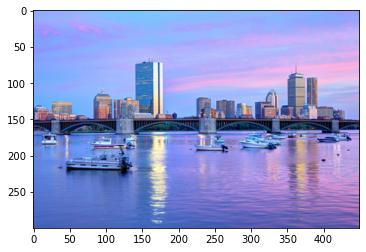

In [14]:
# Load image
file = 'boston_skyline.jpg'
image = Image.open(file)

# Reduce resolution
image = reduceRes(image,2)

# Convert to grayscale
gray = rgb2gray(image)

# Smooth image
gray = boxFilter(gray,3)

plt.imshow(image)

# Find Corners
with a threshold of <100 pixels/corner

pixels/corner: 1901.0
pixels/corner: 305.0
pixels/corner: 130.0
pixels/corner: 81.0
Threshold: 0.00010000000000000003
Corners: 1670


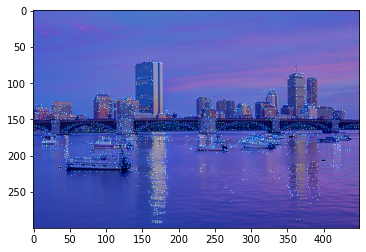

In [15]:
ratio = 1000
corners = reducedHarris(gray,ratio)

plt.imshow(image)
plt.imshow(corners>0, cmap = "jet", alpha = 0.4)

# Find corners with neighbors in filter window
Becaues the NCC of both these arrays are equal:\
0,0,0 -> 0,0,0\
0,1,0 -> 0,5,0\
0,0,0 -> 0,0,0\
Isolated corners are matches on both images
This also means that the NCC filter needs to be larger than 3-by-3

Previous corners: 1670.0
Better corners: 1421.0


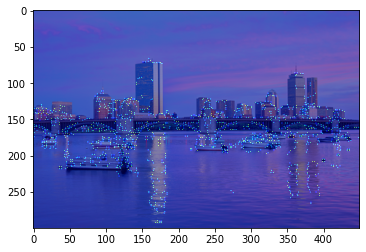

In [16]:
width = 7
num_corners = 2
better_corners = neighboringCorner(corners,width,num_corners)

plt.imshow(image)
plt.imshow(better_corners>0, cmap = "jet", alpha = 0.5)

# Match corners with Normalized Cross Correlation
Throwout matches with more than one best match

In [17]:
corners2 = np.copy(better_corners)
num_matches = 3
matches = findMatches(better_corners,corners2,width,num_matches)

print(matches)

Match # 1
Match # 2
Match # 3
[[206. 122. 206. 122.]
 [144. 228. 144. 228.]
 [155.  61. 155.  61.]]


# Put it all together

Preprocessing

In [18]:
# Load image
file = 'boston_skyline.jpg'
image = Image.open(file)

# Reduce resolution
image = reduceRes(image,2)

# Convert to grayscale
gray = rgb2gray(image)

# Smooth image
gray = boxFilter(gray,3)

Split images

In [19]:
# Split image into top left and bottom right with overlap
r,c = gray.shape
split = 5
topleft = gray[0:np.int(np.floor(r-r/split)), 0:np.int(np.floor(c-c/split))]
botright = gray[np.int(np.floor(r-(split-1)*r/split)):, np.int(np.floor(c-(split-1)*c/split)):]

Find corners

In [23]:
# Find sparse corners
print('Finding corners...')
ratio = 1000
corners1 = reducedHarris(topleft,ratio)
corners2 = reducedHarris(botright,ratio)

# Improve corners
print('Improving corners...')
width = 7
num_corners = 2
better_corners1 = neighboringCorner(corners1,width,num_corners)
better_corners2 = neighboringCorner(corners2,width,num_corners)

# Find matches
print('Finding matches...')
num_matches = 10
matches = findMatches(better_corners1,better_corners2,width,num_matches)

Finding corners...
Threshold: 0.0010000000000000002
Corners: 948
Threshold: 0.0010000000000000002
Corners: 868
Improving corners...
Previous corners: 948.0
Better corners: 787.0
Previous corners: 868.0
Better corners: 710.0
Finding matches...
Match # 1
Match # 2
Match # 3
Match # 4
Match # 5
Match # 6
Match # 7
Match # 8
Match # 9
Match # 10


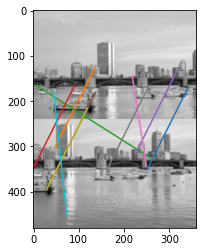

In [21]:
def drawLines(image1,image2,matches):

    offset = image1.shape[0]
    x = np.copy(matches[:,0:4:2])
    x[:,1] = x[:,1] + offset
    y = np.copy(matches[:,1:4:2])

    both = np.vstack([image1,image2])
    plt.imshow(both,cmap='gray')
    for i in range(0,x.shape[0]):
        plt.plot(y[i,:],x[i,:])
    
    return

drawLines(topleft,botright,matches)